# Code to plot PSDDF data
### Version 1.2

Date: 08/01/2023

Author: Jonathan Moore


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.pyplot import cm
import os
import re
from PSDDF_module import PSDDF_run
from GraphFunctions import plot_settlement
from GraphFunctions import plot_Layer_data

## Input Directories

In [20]:
### Read in the results files

# Dir to folder containing output files
# Output_Dir = r"C:\Users\u4hncjjm\Documents\SMIIL"
# Output_Dir = r"C:\Users\u4hncjjm\Documents\Caminada_Files\Work\PSDDF\Output"
# Output_Dir = r"C:\Users\u4hncjjm\Documents\PSDDF\Res"

# List of output dirs
output_dir_list = [r"C:\Users\u4hncjjm\Documents\Caminada_Files\Work\PSDDF\Output",
                  ]

# List of output filenames
output_filename_list = ["Site A_Anchor",
                        ]

field_data_list = [r"C:\Users\u4hncjjm\Documents\Caminada_Files\Moore_SiteA\Site_A_Settlements.xlsx",
                   ]
# List of units used
units_list = ["SI", "SI", "SI"]

# Enter the number of PSDDF runs that should be analyzed
num_PSDDF_runs = len(output_filename_list)

# Init list to hold the PSDDF data information
PSDDF_data_list = [0] * num_PSDDF_runs

#### Init variables to hold the unit dictionaries

In [21]:
# Init dict to hold the possible units
unit_selection_dict = {"SI": {"t": "day", "L": "m", "gamma_w": "kN/m^{3}", "stress": "kN/m^2", "k":"m/day" },
                       "US": {"t": "day", "L": "ft", "gamma_w": "lbs/ft^{3}", "stress": "lbs/ft^2", "k":"ft/day" }
                       }

#### Collect pgd, pso, pgc data

In [22]:
for i, (filename, dir) in enumerate(zip(output_filename_list, output_dir_list)):
    # Init the object
    PSDDF_data_list[i] = PSDDF_run(dir, filename, unit_selection_dict[units_list[i]])

    # Store the psp file
    try: 
        PSDDF_data_list[i].file_2_df("psp")
    except OSError as ve:
        print(ve)

    # Loop through the pgd and pgc files
    for file in ["pgd", "pgc"]:
        try:
            # Calc the layer settlement
            PSDDF_data_list[i].layers_2_layer_settlement(file)
            
            # Calc the total settlement
            PSDDF_data_list[i].layers_2_tot_settlement(file)
        except ValueError as ve:
            print("For file: {}".format(file))
            print(ve)
            continue
    try:
        PSDDF_data_list[i].load_field_data(field_data_xlsx_dir= field_data_list[i])
    except OSError as oe:
        print(oe)
       


#### Plot the surface Elevation

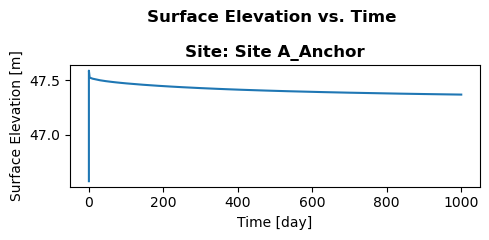

In [23]:
for data in PSDDF_data_list:
    try:
        # Create the figure
        fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (5,2.5))

        # Plot the Surface Elevation vs. Time plot
        axs.plot(data.file_dfs["psp"]["Time"], data.file_dfs["psp"]["Surface Elev"])
        axs.set_title("Surface Elevation vs. Time \n\nSite: " + data.output_name, fontweight = "bold")
        # label plots
        axs.set_xlabel("Time [{}]".format(data.units["t"]))
        axs.set_ylabel("Surface Elevation [{}]".format(data.units["L"]))
        
        # Show plot
        plt.tight_layout()
    except TypeError as te:
        print(te)


#### Plot the Foundation Settlement

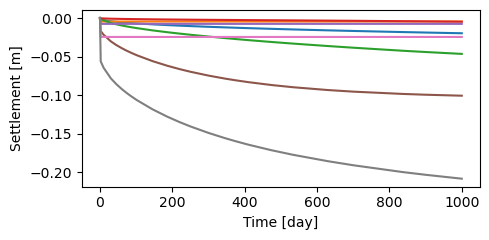

In [24]:
for data in PSDDF_data_list:
    try:
        fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5, 2.5))

        plot_settlement(data, field_data = False, field_data_type = "Settlement", layers = "All", plot_total = True, ax = axs, legend = False, file_type = "pgc", hold_on = False)
        axs.set_title("Foundation settlement vs. Time. \n\nSite: " + data.output_name, fontweight = "bold")
        plt.show()
        
    except TypeError as te:
        print(te)

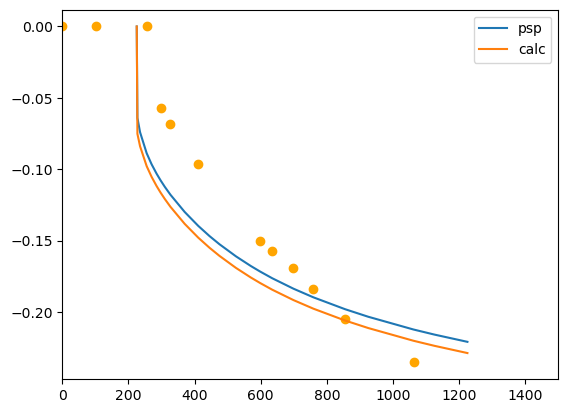

In [25]:

total_settlement = PSDDF_data_list[0].tot_settlements["pgc"]["Settlement"] + PSDDF_data_list[0].tot_settlements["pgd"]["Settlement"]

# Display the psp total settlement
PSDDF_data_list[0].file_dfs["psp"]["Surface Elev"]
psp_tot_settlement = PSDDF_data_list[0].file_dfs["psp"]["Surface Elev"][1:] - PSDDF_data_list[0].file_dfs["psp"]["Surface Elev"][1]

# Plot the psp total settlment
plt.plot(PSDDF_data_list[0].file_dfs["psp"]["Time"][1:] + 225, psp_tot_settlement, label = "psp")

# Plot the calc total settlement
plt.plot(PSDDF_data_list[0].tot_settlements["pgd"]["Time"] + 225, total_settlement, label = "calc")

# Plot the field data
plt.scatter(PSDDF_data_list[0].field_data["Settlement"][0].iloc[:,0], -1 * PSDDF_data_list[0].field_data["Settlement"][0].iloc[:,1], color = "orange")
plt.xlim([0, 1500])
plt.legend()
plt.show()

In [28]:
pd.DataFrame(data = {"Time":PSDDF_data_list[0].tot_settlements["pgc"]["Time"], "Settlement":PSDDF_data_list[0].tot_settlements["pgc"]["Settlement"] + PSDDF_data_list[0].tot_settlements["pgd"]["Settlement"]})

,Time,Settlement
0,0.000000,0.000000
1,2.000002,-0.075171
2,10.000001,-0.083889
3,30.000001,-0.097810
4,45.000000,-0.105345
5,60.000001,-0.111742
6,72.000000,-0.116314
7,85.000001,-0.120853
8,102.000001,-0.126302
9,145.000001,-0.138239


In [29]:
# PSDDF_data_list[0].data_to_excel(PSDDF_data_list[0].layer_dfs["pgc"], folder_dir = r"C:\Users\u4hncjjm\Documents\Caminada_Files\Moore_SiteA", file_name = "Site_A_pgc_layers", sheetnames = ["Layer"])

#### Plot the dredge fill settlement

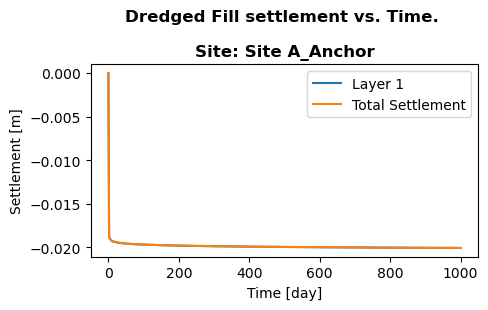

In [ ]:
for data in PSDDF_data_list:
    try:
        fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5, 2.5))

        plot_settlement(data, field_data = False, field_data_type = "Settlement", layers = "All", plot_total = True, ax = axs, legend = True, file_type = "pgd", hold_on = True)
        axs.set_title("Dredged Fill settlement vs. Time. \n\nSite: " + data.output_name, fontweight = "bold")
        plt.show()
        
    except TypeError as te:
        print(te)

#### Plot the Foundation Effective stress data

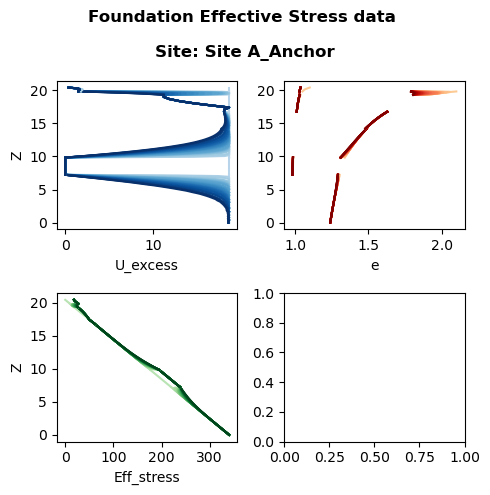

In [ ]:
for data in PSDDF_data_list:
    try:
        # Get the unique times that layer 1 existed for 
        Lay1_times = data.layer_dfs["pgc"][0]["Time"].unique()

        figure, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (5,5))

        plot_Layer_data(data, ["U_excess", "e", "Eff_stress"], ["Z", "Z", "Z"], fig = figure, layers = "All", times = Lay1_times, legend = False, 
                        file_type = "pgc", leg_loc = "best", set_xlabel = True, set_ylabel = [1,0,1], hold_on = True)
        
        # Create title for all plots
        plt.suptitle("Foundation Effective Stress data \n\nSite: " + data.output_name, fontweight = "bold")
        plt.tight_layout()


    except TypeError as te:
        print(te)


#### Plot the dredged fill effective stress plots

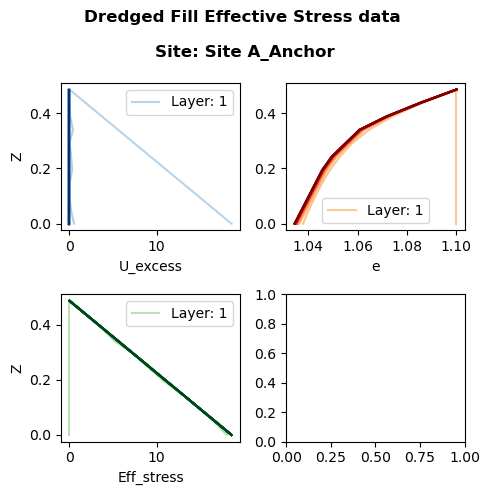

In [ ]:
for data in PSDDF_data_list:
    try:
        # Get the unique times that layer 1 existed for 
        Lay1_times = data.layer_dfs["pgd"][0]["Time"].unique()

        figure, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (5, 5))

        plot_Layer_data(data, ["U_excess", "e", "Eff_stress"], ["Z", "Z", "Z"], fig = figure, layers = "All", times = Lay1_times, legend = True, 
                        file_type = "pgd", leg_loc = "best", set_xlabel = True, set_ylabel = [1,0,1], hold_on = True)
        
        # create title for all plots
        plt.suptitle("Dredged Fill Effective Stress data \n\nSite: " + data.output_name, fontweight = "bold")
        plt.tight_layout()
    
    except TypeError as te:
        print(te)
